# Directional coupler

In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import hilbert
from scipy.signal import find_peaks

from scipy.optimize import curve_fit
import math

from IPython.display import clear_output
import os
import fnmatch
import imageio

In [2]:
# if plain is True no image will be saved during the simulation
plain = True
# give that plain is False, if animation is True the simulation will produce an .mp4 animation, otherwise it will produce .gif animation
animation = False

## Design of the optical circuit

Design of the geometry of the optical component and set the simulation parameters.

     block, center = (0,0.3,0)
          size (100,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.25,12.25,12.25)
     block, center = (0,-0.3,0)
          size (100,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.25,12.25,12.25)


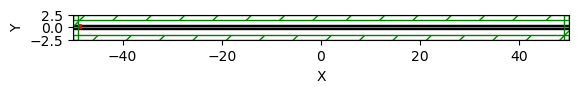

In [3]:
x_dim = 100
y_dim = 5

PML_thick = 1
resolution = 10

WG_width = 0.5
dist = 0.1
eps_mater = 12.25 # silicio

cell= mp.Vector3(x_dim, y_dim, 0)
pml_layers = [mp.PML(PML_thick)]

# Definition of the coupled waveguide
geometry = [
        mp.Block(
            mp.Vector3(x_dim, WG_width, 0),
            center= mp.Vector3(0,(dist + WG_width)/2,0),
            material = mp.Medium(epsilon=eps_mater)),
        mp.Block(
            mp.Vector3(x_dim, WG_width, 0),
            center= mp.Vector3(0,-(dist + WG_width)/2,0),
            material = mp.Medium(epsilon=eps_mater))
        ]

fcen = 1/1.55
df = 0.2
nfreq = 500

# definition of the source
source = [
    mp.Source(
        mp.ContinuousSource(fcen),
        component=mp.Ez,
        center=mp.Vector3(-x_dim/2 + PML_thick + .5, (dist + WG_width)/2, 0),
        size=mp.Vector3(0, 0.8 * WG_width, 0))
    ]

# definition of the simulation object
sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    resolution=resolution
)

# sim.use_output_directory(['./DoubleGuide'])

if (not plain):
    f = plt.figure(dpi=600)
    animate = mp.Animate2D(sim, mp.Ez, f=f)
    plt.close()

sim.plot2D()
plt.show()

Start the simulation setting its duration and time steps for the measurment.

In [4]:
if (plain):
        sim.run(until=5*x_dim)
else:
        if (animation):
                sim.run(mp.at_every(10, animate),
                        until=5*x_dim)
                animate.to_mp4(15, './Coupler.mp4')
        else:
                sim.run(mp.at_every(10, animate),
                        until=5*x_dim)
                animate.to_gif(15, './Coupler.gif')

-----------
Initializing structure...
time for choose_chunkdivision = 0.000277996 s
Working in 2D dimensions.
Computational cell is 100 x 5 x 0 with resolution 10
     block, center = (0,0.3,0)
          size (100,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.25,12.25,12.25)
     block, center = (0,-0.3,0)
          size (100,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.25,12.25,12.25)
time for set_epsilon = 0.0998549 s
-----------


FloatProgress(value=0.0, description='0% done ', max=500.0)

run 0 finished at t = 500.0 (10000 timesteps)


In order to find the coupling length, we look for the minima of the field: we do the slicing of the image produced by the simulation and we recover the field inside the waveguide.

To find the minima, we transform the field into its intensity, namely $I=E^2$. There is an even simplier way, that is apply the Hilbert transform on the field and its norm will return the field envelope.

In [5]:
ez_data_1 = sim.get_array(center= mp.Vector3(0, (dist + WG_width)/2, 0),
                          size=mp.Vector3(x_dim, WG_width), # chiedo di darmi una porzione della griglia larga quanto le guida
                          component=mp.Ez)
ez_data_2 = sim.get_array(center= mp.Vector3(0, -(dist + WG_width)/2, 0), 
                          size=mp.Vector3(x_dim, WG_width),
                          component=mp.Ez)

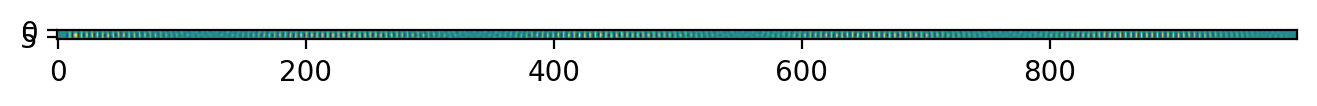

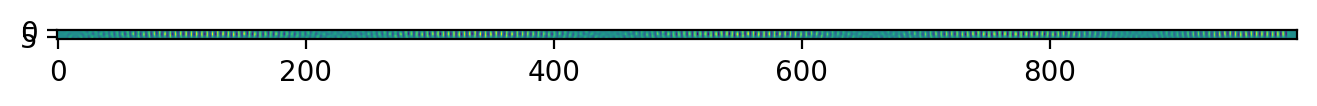

In [6]:
plt.figure(figsize=(8,6), dpi=200)
plt.imshow(np.transpose(ez_data_1)) # transposition allow to see field as horizontal
plt.show()

plt.figure(figsize=(8,6), dpi=200)
plt.imshow(np.transpose(ez_data_2))
plt.show()

Find the Coupling length

### Use distance between minima

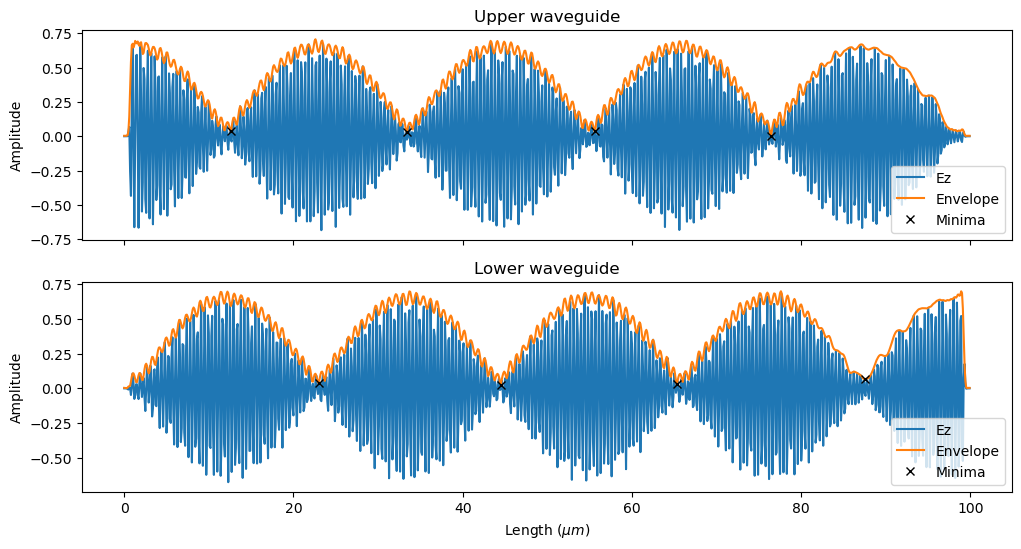

In [7]:
x_coordinate = np.arange(0,x_dim, 1/resolution)

ez_profile_1 = np.sum(ez_data_1, axis=1)
ez_profile_2 = np.sum(ez_data_2, axis=1)

envelope_1 = np.abs(hilbert(ez_profile_1))
envelope_2 = np.abs(hilbert(ez_profile_2))

fig, ax = plt.subplots(2, 1, figsize=(12,6))

ax[0].plot(x_coordinate, ez_profile_1, label='Ez')
ax[1].plot(x_coordinate, ez_profile_2, label='Ez')

peaks_1, _ = find_peaks(-envelope_1, prominence=0.4)
peaks_2, _ = find_peaks(-envelope_2, prominence=0.4)

ax[0].plot(x_coordinate, envelope_1, label='Envelope')
ax[1].plot(x_coordinate, envelope_2, label='Envelope')

ax[0].plot(x_coordinate[peaks_1], envelope_1[peaks_1], "x", color='black', label='Minima')
ax[1].plot(x_coordinate[peaks_2], envelope_2[peaks_2], "x", color='black', label='Minima')

ax[0].set_title('Upper waveguide')
ax[1].set_title('Lower waveguide')

for axs in ax.flat:
    axs.set(xlabel='Length ($\mu m$)', ylabel='Amplitude')
    axs.legend(loc='lower right')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for axs in ax.flat:
    axs.label_outer()

plt.show()

In [8]:
coupling_length = []

for ii in range(len(peaks_1)-1):
    coupling_length += [np.linalg.norm(x_coordinate[peaks_1[ii]] - x_coordinate[peaks_1[ii+1]])/2]

for ii in range(len(peaks_2)-1):
    coupling_length += [np.linalg.norm(x_coordinate[peaks_2[ii]] - x_coordinate[peaks_2[ii+1]])/2]

print('Coupling length from the enveope on the 1st waveguide: ', coupling_length[:len(peaks_1)-1])
print('Coupling length from the enveope on the 2st waveguide: ', coupling_length[len(peaks_1)-1:])

coupling_length_mean = np.mean(coupling_length)
print(f'The coupling length of the coupled waveguides is {coupling_length_mean} um')

Coupling length from the enveope on the 1st waveguide:  [10.399999999999999, 11.100000000000001, 10.400000000000002]
Coupling length from the enveope on the 2st waveguide:  [10.75, 10.399999999999999, 11.100000000000001]
The coupling length of the coupled waveguides is 10.691666666666668 um


### Use FFT

In [9]:
half_x_dim = int(x_dim*resolution/2)

The coupling length of the coupled waveguides extracted from the fft is 10.0 um


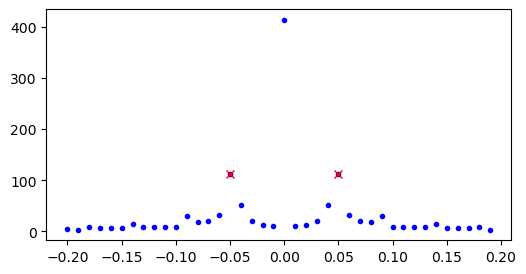

In [10]:
ft_envelope_1 = np.fft.fft(envelope_1)
freq = np.fft.fftfreq(len(envelope_1), d=1/resolution)

i_peak = np.argmax(np.abs(ft_envelope_1[1:half_x_dim])) + 1

fig, ax = plt.subplots(1, 1, figsize=(6,3))
ax.plot(freq[:20], np.abs(ft_envelope_1)[:20], 'b.')
ax.plot(freq[-20:], np.abs(ft_envelope_1)[-20:], 'b.')
ax.plot(freq[i_peak], np.abs(ft_envelope_1)[i_peak], 'rx')
ax.plot(-freq[i_peak], np.abs(ft_envelope_1)[i_peak], 'rx')
# plt.vlines(freq[i_peak], ymin = 0, ymax = np.abs(ft_envelope_1)[i_peak], color = 'r')

print(f'The coupling length of the coupled waveguides extracted from the fft is {1/freq[i_peak]/2} um')

The frequency extracted from the fft can be used as an initial guess while fitting the envelope. Finally, the real periodicity of the envelope is obtained with good precision.

In [11]:
def abs_sin(x, A, w, p):
    return np.abs(A * np.sin(w * x + p))

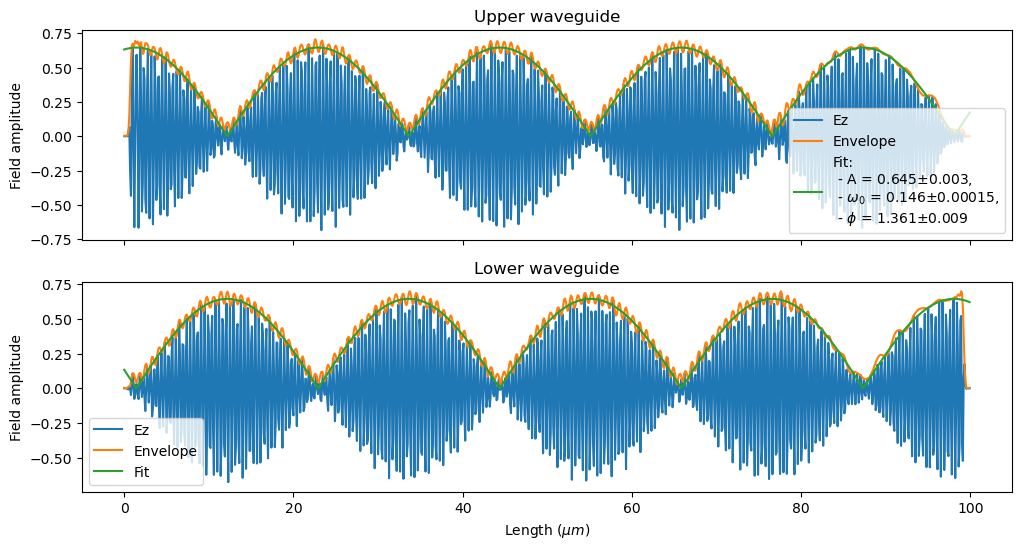

The coupling length of the coupled waveguides is 10.73547342229245 um


In [12]:
popt, pcov = curve_fit(abs_sin, x_coordinate, envelope_1, p0=[np.max(envelope_1), np.pi * freq[i_peak], np.pi / 2])
d_A = np.sqrt(pcov[0][0])
d_w = np.sqrt(pcov[1][1])
d_p = np.sqrt(pcov[2][2])

fig, ax = plt.subplots(2, 1, figsize=(12,6))

ax[0].plot(x_coordinate, ez_profile_1, label='Ez')
ax[1].plot(x_coordinate, ez_profile_2, label='Ez')

ax[0].plot(x_coordinate, envelope_1, label='Envelope')
ax[1].plot(x_coordinate, envelope_2, label='Envelope')

ax[0].plot(x_coordinate, abs_sin(x_coordinate, *popt), '-', 
           label='Fit:\n - A = %5.3f$\pm$%5.3f,\n - $\omega_0$ = %5.3f$\pm$%5.5f,\n - $\phi$ = %5.3f$\pm$%5.3f' 
           % tuple([popt[0], d_A, popt[1], d_w, popt[2], d_p]))
ax[1].plot(x_coordinate, abs_sin(x_coordinate, popt[0], popt[1], popt[2] + np.pi / 2), '-', label='Fit')

ax[0].set_title('Upper waveguide')
ax[1].set_title('Lower waveguide')

for axs in ax.flat:
    axs.set(xlabel='Length ($\mu m$)', ylabel='Field amplitude')
    axs.legend()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for axs in ax.flat:
    axs.label_outer()

plt.show()

print(f'The coupling length of the coupled waveguides is {np.pi /popt[1] / 2} um')

The coupling length depends on several parameters, like the gap between the waveguides:

$l_0 = \frac{\pi}{2\alpha}$

For symmetric slabs:

$\alpha = \frac{2 h^2 q e^{-qg}}{\beta (w + 2/q)(h^2 + q^2)} \left(\frac{2\pi}{\lambda}\right)^2 (n_1^2 - n_2^2)$

$w$ = width

$g$ = gap

$h = \left[\left(\frac{n_1 \omega}{c}\right)^2 - \beta^2 \right]^{1/2}$

$q = \left[\beta^2 - \left(\frac{n_2 \omega}{c}\right)^2 \right]^{1/2}$


## Dependence of the coupling length from the gap between the waveguides

The coupling length is evaluated at different values of the gap

In [13]:
gap_len = []
coupling_len = []

plot=False
freq = np.fft.fftfreq(x_dim*resolution, d=1/resolution)

# for gap in np.arange(0.05, 0.1, 0.005):
for gap in np.logspace(start=np.log10(0.01), stop=np.log10(0.1), num = 30):
    sim.reset_meep()
    geometry = [
        mp.Block(
            mp.Vector3(x_dim, WG_width, 0),
            center= mp.Vector3(0,(gap + WG_width)/2,0),
            material = mp.Medium(epsilon=eps_mater)),
        mp.Block(
            mp.Vector3(x_dim, WG_width, 0),
            center= mp.Vector3(0, -(gap + WG_width)/2,0),
            material = mp.Medium(epsilon=eps_mater))
        ]
    
    source = [
        mp.Source(
            mp.ContinuousSource(fcen),
            component=mp.Ez,
            center=mp.Vector3(-x_dim/2 + PML_thick + .5, (gap + WG_width)/2, 0),
            size=mp.Vector3(0, 0.8*WG_width, 0))
    ]

    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=source,
        resolution=resolution
    )

    # sim.plot2D()
    # plt.show()

    sim.run(until=5*x_dim)
    
    ez_data_1 = sim.get_array(  center= mp.Vector3(0,(gap + WG_width)/2,0), 
                                size=mp.Vector3(x_dim, WG_width),
                                component=mp.Ez)
    ez_data_2 = sim.get_array(  center= mp.Vector3(0,-(gap + WG_width)/2,0), 
                                size=mp.Vector3(x_dim, WG_width),
                                component=mp.Ez)

    ez_profile_1 = np.sum(ez_data_1, axis=1)
    ez_profile_2 = np.sum(ez_data_2, axis=1)

    envelope_1 = np.abs(hilbert(ez_profile_1))
    envelope_2 = np.abs(hilbert(ez_profile_2))

    ft_envelope_1 = np.fft.fft(envelope_1)
    i_peak = np.argmax(np.abs(ft_envelope_1[1:half_x_dim])) + 1

    popt, _ = curve_fit(abs_sin, x_coordinate, envelope_1, p0=[np.max(envelope_1), np.pi * freq[i_peak], np.pi / 2])

    if (plot):
        fig, ax = plt.subplots(1, 1, figsize=(12,6))
        x_coordinate = np.arange(0,x_dim, 1/resolution)
        ax.plot(x_coordinate, ez_profile_1)
        ax.plot(x_coordinate, ez_profile_2)

        ax.plot(x_coordinate, envelope_1, label='1st waveguide')
        ax.plot(x_coordinate, envelope_2, label='2nd waveguide')

        ax.set_xlabel('Waveguide ($\mu m$)')
        ax.set_ylabel('Field amplitude')

        plt.title(f'Field oscillation for a gap of {gap} um')
        plt.legend()
        plt.show()

        fig, ax = plt.subplots(1, 1, figsize=(6,3))
        ax.plot(freq, np.abs(ft_envelope_1), 'b.')
        ax.plot(freq[i_peak], np.abs(ft_envelope_1)[i_peak], 'rx')
        ax.plot(-freq[i_peak], np.abs(ft_envelope_1)[i_peak], 'rx')

        plt.show()

    coupling_len += [np.pi /popt[1] / 2]
    gap_len += [gap]
    clear_output()

In [14]:
def fit_exp(x, A, q, c):
    return A * np.exp(q * x) + c

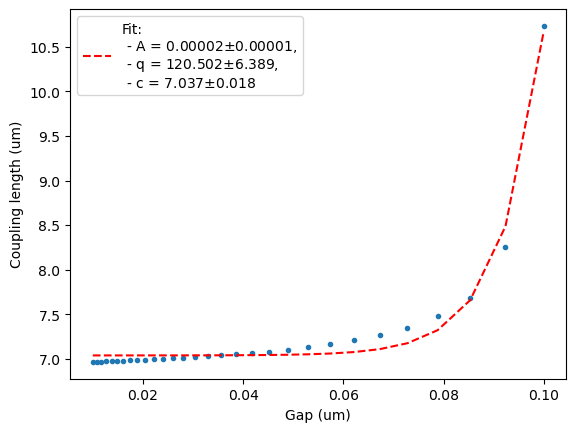

In [15]:
popt, pcov = curve_fit(fit_exp, gap_len, coupling_len, p0=[1, 1, 7])
d_A = np.sqrt(pcov[0][0])
d_q = np.sqrt(pcov[1][1])
d_c = np.sqrt(pcov[2][2])

fig, ax = plt.subplots(1, 1)
ax.plot(gap_len, coupling_len, '.')
fit_coupling_length = [fit_exp(gg, *popt) for gg in gap_len]
ax.plot(gap_len, fit_coupling_length, 'r--', 
        label='Fit:\n - A = %5.5f$\pm$%5.5f,\n - q = %5.3f$\pm$%5.3f,\n - c = %5.3f$\pm$%5.3f' % tuple([popt[0], d_A, popt[1], d_q, popt[2], d_c]))

ax.set_xlabel('Gap (um)')
ax.set_ylabel('Coupling length (um)')

plt.legend()
plt.show()

## Dependence of the coupling length from the contrast of the refractive indexes

In [16]:
print(f'The refractive index used previously for the guides is n_1 = {math.sqrt(eps_mater)}')

The refractive index used previously for the guides is n_1 = 3.5


In [17]:
ref_index = []
coupling_len2 = []

plot=False
freq = np.fft.fftfreq(x_dim*resolution, d=1/resolution)

# definition of the source
source = [
    mp.Source(
        mp.ContinuousSource(fcen),
        component=mp.Ez,
        center=mp.Vector3(-x_dim/2 + PML_thick + .5, (dist + WG_width)/2, 0),
        size=mp.Vector3(0, 0.8 * WG_width, 0))
    ]

for ind in np.linspace(1.5, 4, 12):
    sim.reset_meep()
    # Definition of the coupled waveguide
    geometry = [
            mp.Block(
                mp.Vector3(x_dim, WG_width, 0),
                center= mp.Vector3(0,(dist + WG_width)/2,0),
                material = mp.Medium(index=ind)),
            mp.Block(
                mp.Vector3(x_dim, WG_width, 0),
                center= mp.Vector3(0,-(dist + WG_width)/2,0),
                material = mp.Medium(index=ind))
            ]

    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=source,
        resolution=resolution
    )

    # sim.plot2D()
    # plt.show()

    sim.run(until=5*x_dim*ind/2)
    
    ez_data_1 = sim.get_array(center= mp.Vector3(0, (dist + WG_width)/2, 0),
                            size=mp.Vector3(x_dim, WG_width),
                            component=mp.Ez)
    ez_data_2 = sim.get_array(center= mp.Vector3(0, -(dist + WG_width)/2, 0), 
                            size=mp.Vector3(x_dim, WG_width),
                            component=mp.Ez)
    
    ez_profile_1 = np.sum(ez_data_1, axis=1)
    ez_profile_2 = np.sum(ez_data_2, axis=1)

    envelope_1 = np.abs(hilbert(ez_profile_1))
    envelope_2 = np.abs(hilbert(ez_profile_2))

    ft_envelope_1 = np.fft.fft(envelope_1)
    i_peak = np.argmax(np.abs(ft_envelope_1[1:half_x_dim])) + 1

    popt, _ = curve_fit(abs_sin, x_coordinate, envelope_1, p0=[np.max(envelope_1), np.pi * freq[i_peak], np.pi / 2])

    if (plot):
        fig, ax = plt.subplots(1, 1, figsize=(12,6))
        x_coordinate = np.arange(0,x_dim, 1/resolution)
        ax.plot(x_coordinate, ez_profile_1)
        ax.plot(x_coordinate, ez_profile_2)

        ax.plot(x_coordinate, envelope_1, label='1st waveguide')
        ax.plot(x_coordinate, envelope_2, label='2nd waveguide')

        ax.set_xlabel('Waveguide ($\mu m$)')
        ax.set_ylabel('Field amplitude')

        plt.title(f'Field oscillation for a refractive index of  {ind}')
        plt.legend()
        plt.show()

        fig, ax = plt.subplots(1, 1, figsize=(6,3))
        ax.plot(freq, np.abs(ft_envelope_1), 'b.')
        ax.plot(freq[i_peak], np.abs(ft_envelope_1)[i_peak], 'rx')
        ax.plot(-freq[i_peak], np.abs(ft_envelope_1)[i_peak], 'rx')

        plt.show()

    coupling_len2 += [np.pi /popt[1] / 2]
    ref_index += [ind]
    clear_output()

In [18]:
def fit_poly_2 (x, a, b):
    return a * x**2 + b

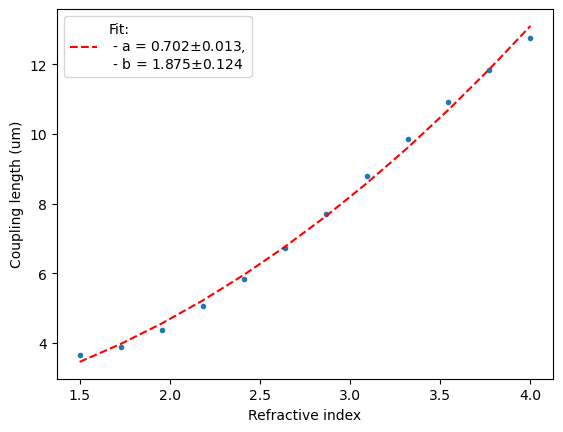

In [19]:
popt2, pcov2 = curve_fit(fit_poly_2, ref_index, coupling_len2, p0=[1, 0])
d_a = np.sqrt(pcov2[0][0])
d_b = np.sqrt(pcov2[1][1])

fig, ax = plt.subplots(1, 1)
ax.plot(ref_index, coupling_len2, '.')
fit_coupling_length2 = [fit_poly_2(ind, *popt2) for ind in ref_index]
ax.plot(ref_index, fit_coupling_length2, 'r--', label='Fit:\n - a = %5.3f$\pm$%5.3f,\n - b = %5.3f$\pm$%5.3f' % tuple([popt2[0], d_a, popt2[1], d_b]))

ax.set_xlabel('Refractive index')
ax.set_ylabel('Coupling length (um)')

plt.legend()
plt.show()

## Dependence of the coupling length from the width of the waveguides

### Asynchronous coupling

-----------
Initializing structure...
time for choose_chunkdivision = 0.000475168 s
Working in 2D dimensions.
Computational cell is 100 x 5 x 0 with resolution 10
     block, center = (0,0.3,0)
          size (100,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.25,12.25,12.25)
     block, center = (0,-0.25,0)
          size (100,0.4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.25,12.25,12.25)
time for set_epsilon = 0.152717 s
-----------


FloatProgress(value=0.0, description='0% done ', max=500.0)

Meep progress: 363.05/500.0 = 72.6% done in 4.0s, 1.5s to go
on time step 7282 (time=364.1), 0.000549322 s/step
run 0 finished at t = 500.0 (10000 timesteps)


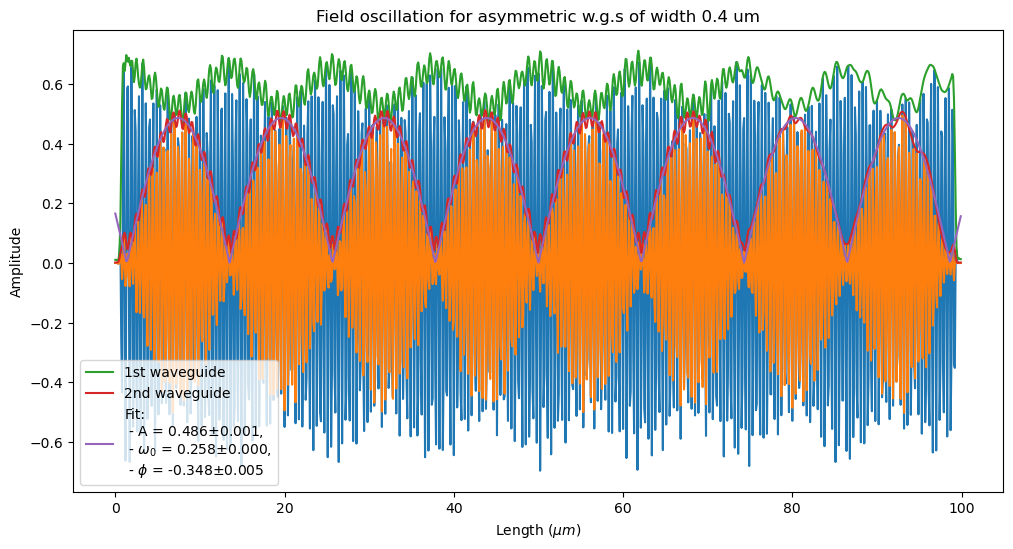

The coupling length is 6.080194707855622 um


In [20]:
width = 0.4

geometry = [
    mp.Block(
        mp.Vector3(x_dim, WG_width, 0),
        center= mp.Vector3(0, (dist + WG_width)/2, 0),
        material = mp.Medium(epsilon=eps_mater)),
    mp.Block(
        mp.Vector3(x_dim, width, 0),
        center= mp.Vector3(0, -(dist + width)/2, 0),
        material = mp.Medium(epsilon=eps_mater))
    ]

source = [
    mp.Source(
        mp.ContinuousSource(fcen),
        component=mp.Ez,
        center=mp.Vector3(-x_dim/2 + PML_thick + .5, (dist + WG_width)/2, 0),
        size=mp.Vector3(0, 0.8*WG_width, 0))
]

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    resolution=resolution
)

# sim.plot2D()
# plt.show()

sim.run(until=5*x_dim)

ez_data_1 = sim.get_array(  center= mp.Vector3(0,(dist + WG_width)/2,0), 
                            size=mp.Vector3(x_dim, WG_width),
                            component=mp.Ez)

ez_data_2 = sim.get_array(  center= mp.Vector3(0,-(dist + width)/2, 0), 
                            size=mp.Vector3(x_dim, width),
                            component=mp.Ez)

ez_profile_1 = np.sum(ez_data_1, axis=1)
ez_profile_2 = np.sum(ez_data_2, axis=1)

envelope_1 = np.abs(hilbert(ez_profile_1))
envelope_2 = np.abs(hilbert(ez_profile_2))

ft_envelope_2 = np.fft.fft(envelope_2)
i_peak = np.argmax(np.abs(ft_envelope_2[1:])) + 1

popt, pcov = curve_fit(abs_sin, x_coordinate, envelope_2, p0=[np.max(envelope_2), np.pi * freq[i_peak], 0])
d_A = np.sqrt(pcov[0][0])
d_w = np.sqrt(pcov[1][1])
d_p = np.sqrt(pcov[2][2])

fig, ax = plt.subplots(1, 1, figsize=(12,6))

x_coordinate = np.arange(0,x_dim, 1/resolution)
ax.plot(x_coordinate, ez_profile_1)
ax.plot(x_coordinate, ez_profile_2)

ax.plot(x_coordinate, envelope_1, label='1st waveguide')
ax.plot(x_coordinate, envelope_2, label='2nd waveguide')

ax.plot(x_coordinate, abs_sin(x_coordinate, *popt), '-', 
        label='Fit:\n - A = %5.3f$\pm$%5.3f,\n - $\omega_0$ = %5.3f$\pm$%5.3f,\n - $\phi$ = %5.3f$\pm$%5.3f' % tuple([popt[0], d_A, popt[1], d_w, popt[2], d_p]))

ax.set_xlabel('Length ($\mu m$)')
ax.set_ylabel('Amplitude')

plt.title(f'Field oscillation for asymmetric w.g.s of width {width} um')
plt.legend()
plt.show()

print(f'The coupling length is {np.pi /popt[1] / 2} um')

In [21]:
width_len = []
coupling_len3 = []
max_power_transfer = []

plot=False
freq = np.fft.fftfreq(x_dim*resolution, d=1/resolution)

for width in [0.5,0.499,0.498,0.497,0.496,0.495,0.494,0.493,0.492,0.49,0.488,0.486,0.484,0.482,0.48]:
    sim.reset_meep()
    geometry = [
        mp.Block(
            mp.Vector3(x_dim, WG_width, 0),
            center= mp.Vector3(0,(dist + WG_width)/2,0),
            material = mp.Medium(epsilon=eps_mater)),
        mp.Block(
            mp.Vector3(x_dim, width, 0),
            center= mp.Vector3(0, -(dist + width)/2,0),
            material = mp.Medium(epsilon=eps_mater))
        ]
    
    source = [
        mp.Source(
            mp.ContinuousSource(fcen),
            component=mp.Ez,
            center=mp.Vector3(-x_dim/2 + PML_thick + .5, (gap + WG_width)/2, 0),
            size=mp.Vector3(0, 0.8*WG_width, 0))
    ]

    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=source,
        resolution=resolution
    )

    # sim.plot2D()
    # plt.show()

    sim.run(until=5*x_dim)
    
    ez_data_1 = sim.get_array(  center= mp.Vector3(0,(dist + WG_width)/2,0), 
                                size=mp.Vector3(x_dim, WG_width),
                                component=mp.Ez)
    ez_data_2 = sim.get_array(  center= mp.Vector3(0,-(dist + width)/2,0), 
                                size=mp.Vector3(x_dim, width),
                                component=mp.Ez)

    ez_profile_1 = np.sum(ez_data_1, axis=1)
    ez_profile_2 = np.sum(ez_data_2, axis=1)

    envelope_1 = np.abs(hilbert(ez_profile_1))
    envelope_2 = np.abs(hilbert(ez_profile_2))

    ft_envelope_2 = np.fft.fft(envelope_2)
    i_peak = np.argmax(np.abs(ft_envelope_2[1:half_x_dim])) + 1

    popt, _ = curve_fit(abs_sin, x_coordinate, envelope_2, p0=[np.max(envelope_2), np.pi * freq[i_peak], 0])

    power_transfer = np.array(envelope_2)/max(envelope_1[0:60*resolution])
    if (plot):
        fig, ax = plt.subplots(1, 1, figsize=(12,6))
        x_coordinate = np.arange(0,x_dim, 1/resolution)
        ax.plot(x_coordinate, ez_profile_1)
        ax.plot(x_coordinate, ez_profile_2)

        ax.plot(x_coordinate, envelope_1, label='1st waveguide')
        ax.plot(x_coordinate, envelope_2, label='2nd waveguide')
        ax.plot(x_coordinate, abs_sin(x_coordinate, *popt), 
                label='Fit:\n - A = %5.3f,\n - $\omega_0$ = %5.3f,\n - $\phi$ = %5.3f' 
                % tuple(popt))

        ax.set_xlabel('Waveguide ($\mu m$)')
        ax.set_ylabel('Field amplitude')

        plt.title(f'Field oscillation bottom wg of width {width} um')
        plt.legend()
        plt.show()

        fig, ax = plt.subplots(1, 1, figsize=(12,6))
        ax.plot(x_coordinate, power_transfer, label = 'power transfer ratio')

        ax.set_xlabel('Waveguide ($\mu m$)')
        ax.set_ylabel('Ratio')

        plt.title(f'Power transfer ratio at bottom wg of width {width} um')
        plt.legend()
        plt.show()

        fig, ax = plt.subplots(1, 1, figsize=(6,3))
        ax.plot(freq, np.abs(ft_envelope_1), 'b.')
        ax.plot(freq[i_peak], np.abs(ft_envelope_1)[i_peak], 'rx', label=f'guess freq {np.pi * freq[i_peak]}')
        ax.plot(-freq[i_peak], np.abs(ft_envelope_1)[i_peak], 'rx')
        plt.legend()
        plt.show()
    else:
        clear_output()

    coupling_len3 += [np.pi /popt[1] / 2]
    width_len += [width]
    max_power_transfer += [max(power_transfer[:60*resolution])]

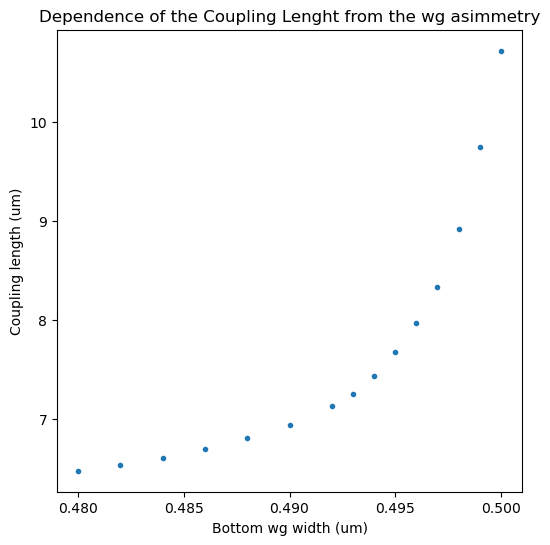

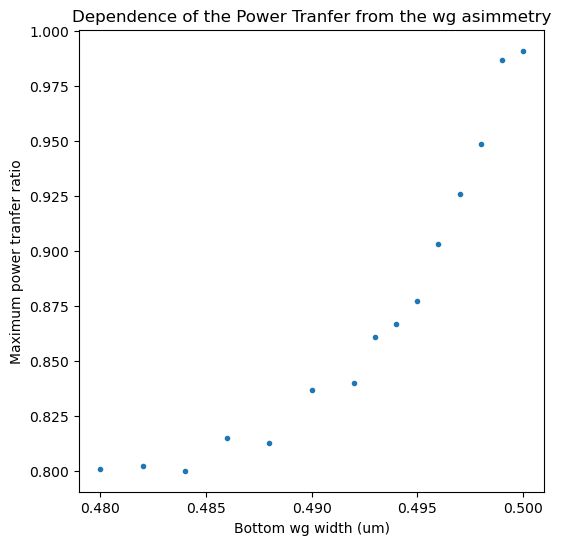

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.locator_params(axis='x', nbins=7)

ax.plot(width_len, coupling_len3, '.')
ax.set_title('Dependence of the Coupling Lenght from the wg asimmetry')
ax.set_xlabel('Bottom wg width (um)')
ax.set_ylabel('Coupling length (um)')

plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.locator_params(axis='x', nbins=7)

ax.plot(width_len, max_power_transfer, '.')
ax.set_title('Dependence of the Power Tranfer from the wg asimmetry')
ax.set_xlabel('Bottom wg width (um)')
ax.set_ylabel('Maximum power tranfer ratio')

plt.show()

Widths like w=0.4925 or w=0.4875 don't behave well during the simulation